In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%load_ext line_profiler

In [3]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [4]:
import json
import os
import sys
sys.path.insert(0, os.path.abspath('../src/'))

import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [5]:
from predict import Model
from predict import load_data
from utils import imsetshow

## 1.0 Configuration

In [6]:
config_file_path = os.path.abspath(os.path.join('..', "config", "config.json"))
print("config_file_path : " + config_file_path)
with open(config_file_path, "r") as read_file:
    config = json.load(read_file)

config_file_path : /data/config/config.json


In [7]:
#show availables models
checkpoint_dir = os.path.join('..', config["paths"]["checkpoint_dir"])
print("checkpoint_dir path : " + checkpoint_dir)

checkpoint_dir path : ../models/weights


In [8]:
#display all existing models before choosing
#subfolder need as HRNet.pth and ShiftNet.pth inside
#empty subfolders are aborted training
!tree $checkpoint_dir

../models/weights
|-- batch_16_views_32_min_32_beta_50.0_time_2019-07-16-22-25-08-596358
|-- batch_16_views_4_min_32_beta_50.0_time_2019-07-17-08-20-05-457890
|-- batch_16_views_4_min_32_beta_50.0_time_2019-07-17-08-20-28-075261
|-- batch_16_views_4_min_32_beta_50.0_time_2019-07-17-08-21-18-927467
|-- batch_16_views_4_min_32_beta_50.0_time_2019-07-17-08-29-22-215685
|-- batch_2_views_32_min_32_beta_50.0_time_2019-07-16-22-25-36-882783
|-- batch_32_views_16_min_16_beta_50.0_time_2019-07-17-19-10-01-286353
|   |-- HRNet.pth
|   `-- ShiftNet.pth
|-- batch_32_views_32_min_32_beta_50.0_time_2019-07-16-22-11-36-867134
|-- batch_32_views_32_min_32_beta_50.0_time_2019-07-16-22-17-00-666580
|-- batch_32_views_32_min_32_beta_50.0_time_2019-07-17-19-08-13-884091
|-- batch_32_views_8_min_32_beta_50.0_time_2019-07-17-08-19-39-195674
|-- batch_4_views_32_min_32_beta_50.0_time_2019-07-16-22-26-30-093576
|-- batch_4_views_32_min_32_beta_50.0_time_2019-07-16-22-27-18-414831
|-- batch_4_views_8_min_16_b

In [9]:
run_subfolder = 'batch_32_views_16_min_16_beta_50.0_time_2019-07-17-19-10-01-286353'

In [10]:
checkpoint_filename = 'HRNet.pth'
checkpoint_file = os.path.join(checkpoint_dir, run_subfolder, checkpoint_filename)
# print(checkpoint_file)
assert os.path.isfile(checkpoint_file)
print("checkpoint_file : " + checkpoint_file)

checkpoint_file : ../models/weights/batch_32_views_16_min_16_beta_50.0_time_2019-07-17-19-10-01-286353/HRNet.pth


## 1.1 Load model

In [11]:
model = Model(config)
model.load_checkpoint(checkpoint_file=checkpoint_file)

## 1.2 Load data

In [12]:
data_path = os.path.abspath(os.path.join('..', config['paths']['prefix']))
current_data_path = os.path.join('..', os.getcwd(), config['paths']['prefix'])[:-1]
current_data_path

'/data/notebooks/data'

In [13]:
#fix relative path in json while running in notebook subfolder
!ln -s $data_path $current_data_path

In [14]:
train_dataset, val_dataset, test_dataset, baseline_cpsnrs = load_data(config_file_path, val_proportion=0.10, top_k=-1)

## 1.3 Run evaluation

In [15]:
results = model.evaluate(train_dataset, val_dataset, test_dataset, baseline_cpsnrs)

## 1.4 Benchmark % ESA Baseline

In [16]:
results.describe().T

,count,mean,std,min,25%,50%,75%,max
ESA,1450.0,4.637892e+01,3.779463,3.144905e+01,4.393971e+01,4.630870e+01,4.864591e+01,5.972002e+01
model,1160.0,4.885839e+01,3.476779,3.879620e+01,4.650735e+01,4.868001e+01,5.095293e+01,6.085154e+01
score,1160.0,9.512023e-01,0.029981,7.919326e-01,9.375115e-01,9.556239e-01,9.706841e-01,1.103778e+00
mean_clr,1450.0,3.882206e+06,190040.649017,2.340645e+06,3.815749e+06,3.916757e+06,4.009718e+06,4.158178e+06
std_clr,1450.0,3.742484e+05,115999.730132,4.393662e+04,3.036766e+05,3.845572e+05,4.557472e+05,1.046887e+06


In [17]:
results.loc[results['part'] == 'train'].describe().loc['mean']

ESA         4.649333e+01
model       4.884095e+01
score       9.516266e-01
mean_clr    3.874490e+06
std_clr     3.794913e+05
Name: mean, dtype: float64

In [18]:
results.loc[results['part'] == 'val'].describe().loc['mean']

ESA         4.645452e+01
model       4.901536e+01
score       9.473837e-01
mean_clr    3.891978e+06
std_clr     3.752526e+05
Name: mean, dtype: float64

In [19]:
results.loc[results['part'] == 'test'].describe().loc['mean']

ESA         4.593679e+01
model                NaN
score                NaN
mean_clr    3.906075e+06
std_clr     3.549721e+05
Name: mean, dtype: float64

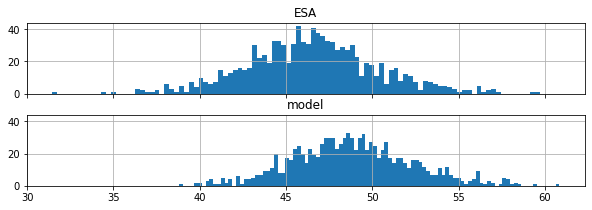

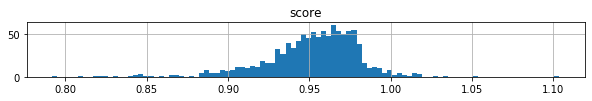

In [20]:
results.loc[results['part']=='train'].hist(column=['ESA', 'model'],
                                           sharex=True, sharey=True, bins=100, layout=(2,1), figsize=(10, 3));
results.loc[results['part']=='train'].hist(column=['score'],
                                           bins=100, figsize=(10, 1));

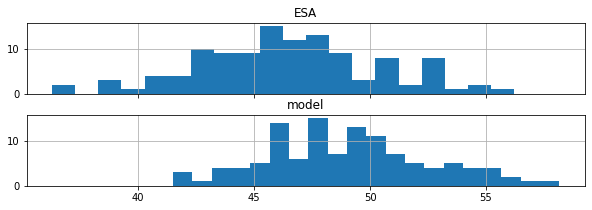

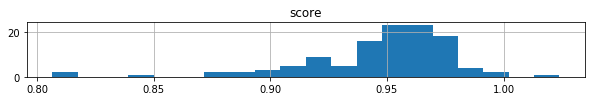

In [21]:
results.loc[results['part']=='val'].hist(column=['ESA', 'model'],
                                           sharex=True, sharey=True, bins=20, layout=(2,1), figsize=(10, 3));
results.loc[results['part']=='val'].hist(column=['score'],
                                           bins=20, figsize=(10, 1));

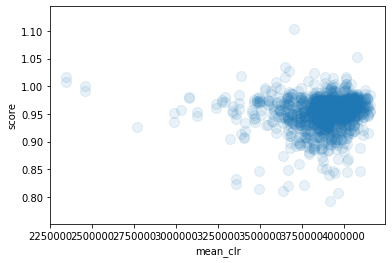

In [22]:
results.plot.scatter('mean_clr', 'score', s=100, alpha=.1);

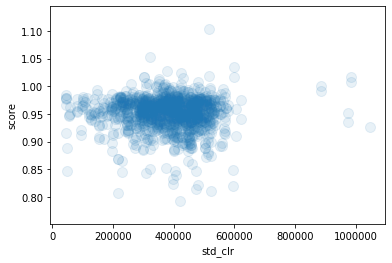

In [23]:
results.plot.scatter('std_clr', 'score', s=100, alpha=.1);

## 1.5 Pretty pics

In [24]:
results[results['part'] == 'val'].sort_values('score')

,ESA,model,clr,part,score,mean_clr,std_clr
imgset1114,36.290002,44.998260,"[4172820, 4171035, 4167210, 4164150, 4163130, ...",val,0.806476,3.964258e+06,216403.254128
imgset0777,38.300894,46.990585,"[4065465, 4001205, 3998910, 3973410, 3968820, ...",val,0.815076,3.495819e+06,474123.562183
imgset0411,39.046084,46.035709,"[4177920, 4177665, 4167720, 4160835, 4155990, ...",val,0.848169,3.665400e+06,594289.206111
imgset0089,36.503225,41.782589,"[4173585, 4169250, 4167975, 4167975, 4165425, ...",val,0.873647,3.636567e+06,522363.780978
imgset0257,43.596855,49.467316,"[4172820, 4170015, 4165425, 4165170, 4161855, ...",val,0.881326,3.792615e+06,511754.752885
imgset0148,38.784131,43.703613,"[4157520, 4157520, 4156500, 4146810, 4135590, ...",val,0.887435,3.863888e+06,321879.407090
imgset1012,46.537066,52.412334,"[4162365, 4162110, 4161600, 4161345, 4161090, ...",val,0.887903,3.991981e+06,272614.696031
imgset1060,40.974002,45.800018,"[4161600, 4152930, 4141200, 4137885, 4124625, ...",val,0.894629,3.838345e+06,276293.918624
imgset0738,44.175679,49.296692,"[4177920, 4177920, 4170525, 4166700, 4165680, ...",val,0.896119,3.904730e+06,437583.473957
imgset0372,42.605861,47.510284,"[4177920, 4177920, 4177920, 4175880, 4174860, ...",val,0.896771,3.958301e+06,428727.335230


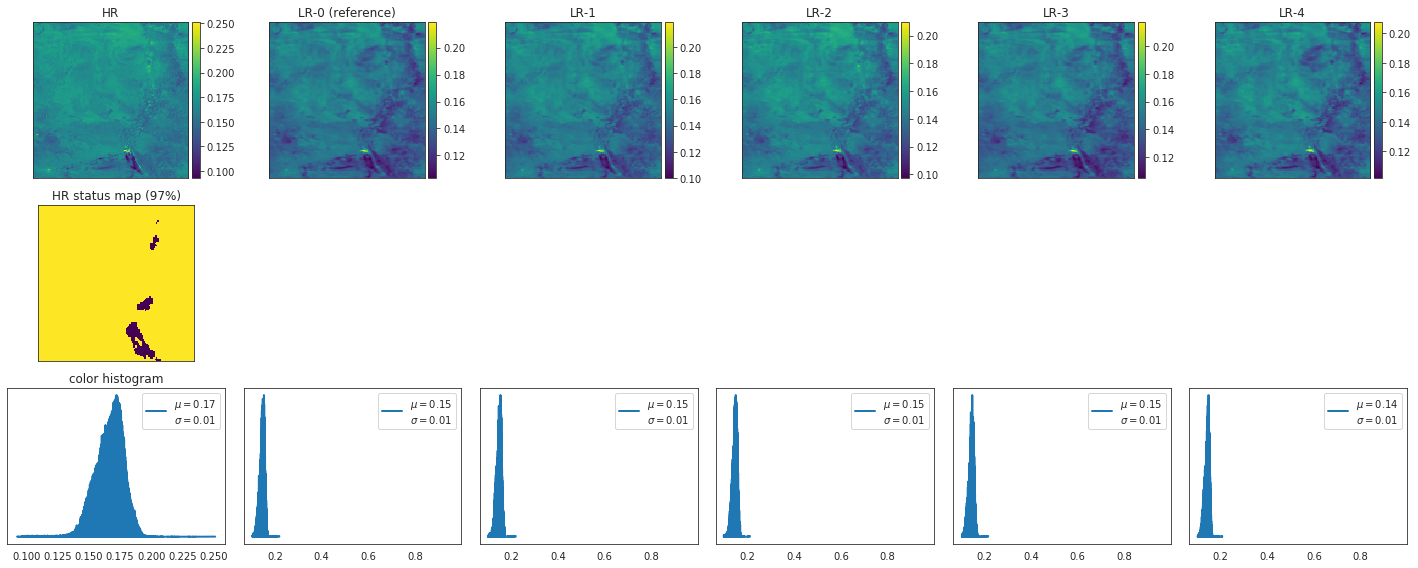

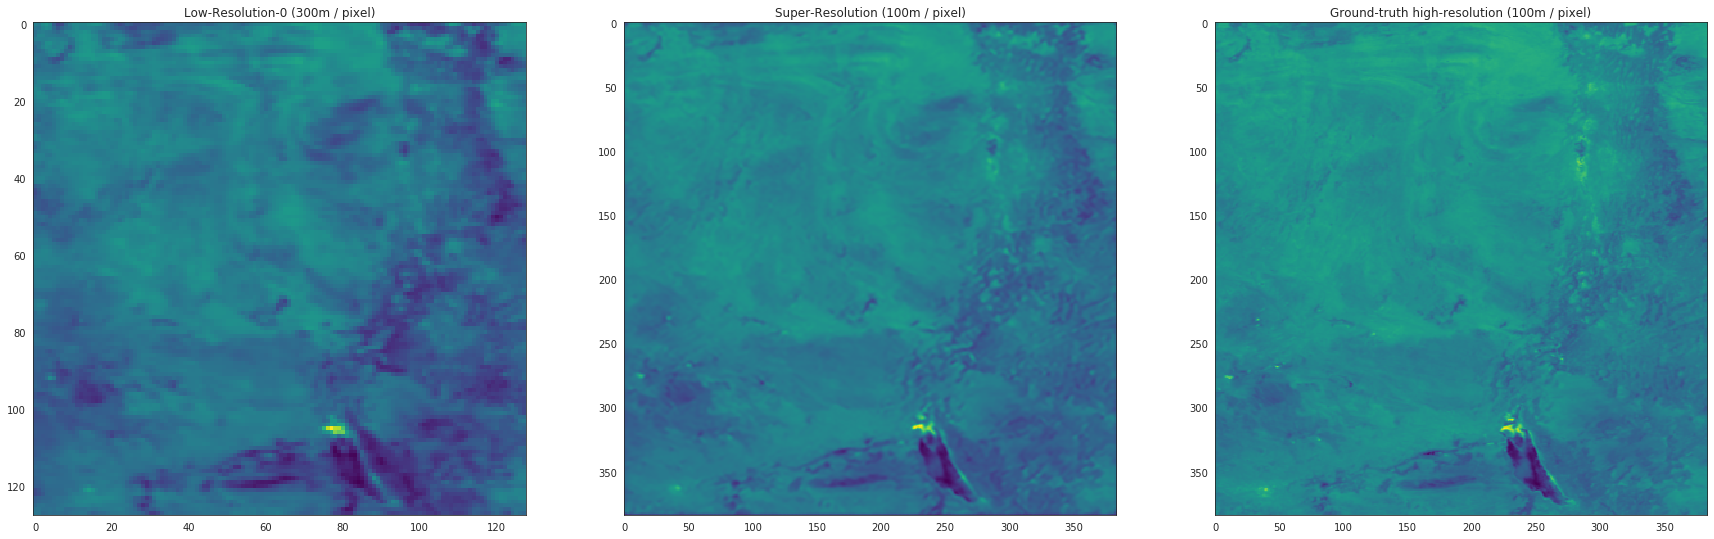

In [26]:
imset = val_dataset['imgset1012']
sr, scPSNR = model(imset)

imsetshow(imset, k=5, figsize=(20,8), resample=False, show_histogram=True, show_map=True)

plt.figure(figsize=(30, 10))
plt.subplot(131);  plt.imshow(imset['lr'][0]);  plt.title('Low-Resolution-0 (300m / pixel)');
plt.subplot(132);  plt.imshow(sr);  plt.title('Super-Resolution (100m / pixel)');
plt.subplot(133);  plt.imshow(imset['hr']);  plt.title('Ground-truth high-resolution (100m / pixel)');

## 1.6 Generate submission file

In [ ]:
model.generate_submission_file(imset_dataset=test_dataset, out='../submission')

generating solutions: 

**

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


**

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


**

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


**

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


**

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


*

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


**

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


***

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


*